# Oscillation forcée d'une barre métallique

In [1]:
%matplotlib inline

import numpy as np
from scipy import linalg as la
import matplotlib.pyplot as plt
from matplotlib import colormaps
from matplotlib.colors import Normalize
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "font.size": 14,
})

## Description et données du problème

On se propose d'étudier le comportement vibratoire d'une barre métallique soumise à un mouvement du support :

![Barre métallique](pictures/TD5-BarRectangulaire.png)

La barre de section rectangulaire est composé d'un métal présentant un module de conservation $E = 210\,\mathrm{GPa}$, un facteur de perte $\eta = 0.01$, et d'une densité $\rho = 7830\,\mathrm{kg\,mm}^{-3}$.

Les autres données du problème sont :

| $L$     | $h$     | $b$     | $\rho$  | $E$     | $\eta$  | $\omega_{\mathrm{gr}}$ | $U_{\mathrm{gr}}$ | 
|:-------:|:-------:|:-------:|:-------:|:-------:|:-------:|:----------------------:|:----------------------:|
| $1000\,\mathrm{mm}$ | $10\,\mathrm{mm}$ | $20\,\mathrm{mm}$ | $7830\,\mathrm{kg\,m}^{-3}$ | $210\,\mathrm{GPa}$ | $0.01$ | $10\,\mathrm{rad\,ms^{-1}}$ | $1\,\mathrm{mm}$ |

### Système d'unité consistent

Un point important sur les unités à utiliser : il faut travailler dans un **système d'unité consistent**. Nous comprenons aisément que toutes les longueurs doivent être exprimées dans la même unité, les *millimètres* par exemple. Cependant, ce n'est pas le seul point de vigilance. En effet, le choix pour les unités de longueur, de masse, de temps, d'effort, etc. ne peut être fait de manière indépendante. Ces unités sont liées entre elles. 

Par exemple, si nous nous fixons les *millimètres* comme unité de longueur, les *Newton* comme unité de force, cela implique qu'une pression, une contrainte, ou encore un module d'élasticité doit être exprimé en *Newton par millimètre carré*.

Ci-dessous un version compacte d'un [tableau récapitulatif de différents systèmes d'unité consistent](https://www.dynasupport.com/howtos/general/consistent-units) plus complet :

| Masse          | Longueur      | Temps         | Force                 | Contrainte     | Densité               | Module d'Young     |
|----------------|---------------|---------------|-----------------------|----------------|-----------------------|--------------------|
| $\mathrm{kg}$  | $\mathrm{m}$  | $\mathrm{s}$  | $\mathrm{N}$          | $\mathrm{Pa}$  | $7830$                | $210\cdot{}10^{9}$ |
| $\mathrm{kg}$  | $\mathrm{mm}$ | $\mathrm{ms}$ | $\mathrm{kN}$         | $\mathrm{GPa}$ | $7.830\cdot{}10^{-6}$ | $210$              |
| $\mathrm{g}$   | $\mathrm{mm}$ | $\mathrm{s}$  | $\mathrm{10^{-6}\,N}$ | $\mathrm{Pa}$  | $7.830\cdot{}10^{-3}$ | $210\cdot{}10^{9}$ |
| $\mathrm{g}$   | $\mathrm{mm}$ | $\mathrm{ms}$ | $\mathrm{N}$          | $\mathrm{MPa}$ | $7.830\cdot{}10^{-3}$ | $210\cdot{}10^{3}$ |
| $\mathrm{ton}$ | $\mathrm{mm}$ | $\mathrm{s}$  | $\mathrm{N}$          | $\mathrm{MPa}$ | $7.830\cdot{}10^{-9}$ | $210\cdot{}10^{3}$ |

Chaque ligne du tableau représente un système d'unité consistent. La première ligne reprend le système d'unité international. Il n'est pas forcément adéquat d'exprimer toutes les données dans ce système d'unité. Par exemple, ici sur une structure métallique où certaines dimensions sont de quelques millimètres, il est plus pertinent de travailler dans le système $(\mathrm{g, mm, ms, N, MPa})$, soit l'avant dernière ligne du tableau ci-dessus.



In [2]:
rho = 7.83e-03 # Density [g/mm3]
E = 210E3 # Young's modulus [MPa]
eta = 0.01 # Facteur de perte [-]
Estar = E * (1.0 + 1.0j*eta) # Module complexe
L = 1000 # Length [mm]
h = 10 # Thickness [mm]
b = 20 # Width [mm]
A = h*b # Area of the cross-sectionn [mm2]

wgr = 10.0 # Pulsation excitation [rad/ms]
Ugr =  1.0 # Amplitude mvt du support [mm]

## Réponse stationnaire

### Système d'équation

La barre métallique est excitée par le support où elle est encastrée et est laissée libre à l'autre extrémité. Le système d'équations décrivant le mouvement de la barre est :
$$
\left\{
    \begin{array}{l}
        \rho A \ddot{\mathcal{u}}(t,x)
        -
        E^*A\,{\mathcal{u}}^{\prime\prime}(t,x)
        = 0, \forall{x},
        \\[3pt]
        \mathcal{u}(t,x=0) = U_{\mathrm{gr}}\mathrm{e}^{\mathrm{i}\omega{}t},
        \\[3pt]
        \mathcal{u}^{\prime}(t,x=L) = 0,
    \end{array},
    \quad\forall{t}.
\right.
$$

Remarques :

* La première équation est l'équation régissant le mouvement dans la barre. Cette équation doit être vérifiée à chaque position $x$ de la barre, et à chaque instant $t$.
* La deuxième équation exprime le fait qu'à la position $x=0$, le déplacement est imposé égal à celui du support.
* La troisième équation exprime le fait qu'à la position $x=L$, la barre est libre. En d'autres termes, il n'y a pas d'effort qui s'applique en $x=L$. Pour rappel, l'expression de l'effort normal $N$ en fonction du déplacement est :
  $$
  N = E^*A u^{\prime}.
  $$
  Donc :
  $$
    N(t,x=L) = 0
    \quad\Leftrightarrow\quad
    E^*A u^{\prime}(t,x=L) = 0
    \quad\Leftrightarrow\quad
    u^{\prime}(t,x=L) = 0.
  $$
  Nous retrouvons cette troisième équation de notre système.
* Le système d'équation est écrit dans $\mathbb{C}$ car la relation de comportement (lien contrainte/déformation, ou effort/déplacement) est connue dans $\mathbb{C}$ uniquement de par la présence du terme de dissipation d'énergie. C'est cela qui fait apparaître le module complexe : 
  $$
    E^* = E(1+\mathrm{i}\eta).
  $$
  En résolvant le système d'équations ci-dessus, nous allons d'abord obtenir les déplacements dans $\mathbb{C}$. Le déplacement ``physique'' (que l'on peut mesurer en réalité), final, est obtenu en prenant la partie réelle de ce déplacement complexe.
* Finalement, nous pouvons noter l'absence de conditions initiales (ce qui se passe à $t=0$) dans notre système d'équations. Elles ont été omises volontairement, car nous nous intéressons ici au régime établi (et non au régime transitoire), c'est-à-dire au mouvement de la barre après un certain temps où les conditions initiales n'ont plus d'importance. Peu importe les conditions initiales (barre initiale au repos ou bien barre déformée à l'instant initial par exemple), nous savons qu'à partir d'un certain temps, les réponses seront identiques. Cela est dû à la présence du terme de dissipation : l'énergie initiale se dissipe au cours du temps jusqu'à devenir négligeable par rapport à l'énergie introduite par le mouvement du support. Cela a été vu sur les systèmes à 1 DDL, et est bien schématisé dans la [vidéo YouTube suivante](https://youtu.be/vLaFAKnaRJU?si=spdlonP1XFDm3Ol5&t=651) (à partir de 10:50).

### Amplitude complexe

Nous cherchons une solution stationnaire sous la forme suivante :
$$
\mathcal{u}(t,x) = \mathcal{U}(x)\mathrm{e}^{\mathrm{i}\omega{}t},
$$
signifiant que le déplacement en un point $x$ est harmonique, de pulsation égale à la pulsation d'excitation $^\omega$, et d'amplitude complexe $\mathcal{U}(x)$. La partie imaginaire de $\mathcal{U}(x)$ témoigne d'un potentiel déphasage entre le déplacement à la position $x$ et le mouvement d'entrée imposé par le support. Pour rappel, l'amplitude complexe peut être vue comme :
$$
    \mathcal{U}(x)
    =
    |\mathcal{U}(x)| \mathrm{e}^{-\mathrm{i}\varphi(x)},
    \quad\varphi(x) = -\arg(\mathcal{U}(x)).
$$

Nous pouvons déterminer les expressions des dérivées intervenant dans le système d'équations à résoudre :
$$
\begin{split}
\mathcal{u}(t,x) &= \mathcal{U}(x)\mathrm{e}^{\mathrm{i}\omega{}t},\\
\mathcal{u}^{\prime}(t,x) &= \mathcal{U}^{\prime}(x)\mathrm{e}^{\mathrm{i}\omega{}t},\\
\mathcal{u}^{\prime\prime}(t,x) &= \mathcal{U}^{\prime\prime}(x)\mathrm{e}^{\mathrm{i}\omega{}t},\\
\dot{\mathcal{u}}(t,x) &= \mathrm{i}\omega{}\mathcal{U}(x)\mathrm{e}^{\mathrm{i}\omega{}t},\\
\ddot{\mathcal{u}}(t,x) 
&= (\mathrm{i}\omega{})^2\mathcal{U}(x)\mathrm{e}^{\mathrm{i}\omega{}t}
 = -\omega{}^2\mathcal{U}(x)\mathrm{e}^{\mathrm{i}\omega{}t}.
\end{split}
$$
Ainsi, par substitution dans notre système d'équations, nous obtenons :
$$
\begin{split}
\rho A \ddot{\mathcal{u}}(t,x)
-
E^*A\,{\mathcal{u}}^{\prime\prime}(t,x)
= 0,~~\forall{(t,x)},
&\quad\Rightarrow\quad
-\omega^2\rho A\,\mathcal{U}(x)\mathrm{e}^{\mathrm{i}\omega{}t}
-
E^*A\,\mathcal{U}^{\prime\prime}(x)\mathrm{e}^{\mathrm{i}\omega{}t} = 0,~~\forall{(t,x)}, \\
&\quad\Rightarrow\quad
\boxed{
\omega^2\rho A\,\mathcal{U}(x)
+
E^*A\,\mathcal{U}^{\prime\prime}(x) = 0, \forall{x}.}
\\[10pt]
\mathcal{u}(t,x=0) = U_{\mathrm{gr}}\mathrm{e}^{\mathrm{i}\omega{}t},~~\forall{t},
&\quad\Rightarrow\quad
\mathcal{U}(x=0)\mathrm{e}^{\mathrm{i}\omega{}t} = U_{\mathrm{gr}}\mathrm{e}^{\mathrm{i}\omega{}t},~~\forall{t}, \\
&\quad\Rightarrow\quad
\boxed{
\mathcal{U}(0) = U_{\mathrm{gr}}}
\\[10pt]
\mathcal{u}^{\prime}(t,x=L) = 0,~~\forall{t},
&\quad\Rightarrow\quad
\mathcal{U}^{\prime}(x=L)\mathrm{e}^{\mathrm{i}\omega{}t} = 0,~~\forall{t},\\
&\quad\Rightarrow\quad
\boxed{
\mathcal{U}^{\prime}(L) = 0}
\end{split}
$$

Le module complexe $\mathcal{U}$ est solution de l'équation différentielle ordinaire du second ordre :
$$
\left\{
    \begin{array}{l}
        \mathcal{U}^{\prime\prime}(x) + {\beta^*}^2\,\mathcal{U}(x) = 0, \forall{x},
        \\[3pt]
        \mathcal{U}(0) = U_{\mathrm{gr}},
        \\[3pt]
        \mathcal{U}^{\prime}(L) = 0.
    \end{array}
\right.
$$
Le nombre d'onde complexe est ici donné par : $\beta^* = \omega\sqrt{\rho/E^*}$.

Une solution générale de cette ODE s'écrit :
$$
\boxed{
\mathcal{U}(x) = \mathcal{A}\mathrm{e}^{-\mathrm{i}\beta^* x} + \mathcal{B}\mathrm{e}^{\mathrm{i}\beta^* x}.}
$$
Il nous reste à utiliser les deux conditions aux limites pour identifier les deux constantes $\mathcal{A}$ et $\mathcal{B}$ :
$$
\begin{split}
&\mathcal{U}(0) = U_{\mathrm{gr}},
\quad\Rightarrow\quad
\boxed{\mathcal{A} + \mathcal{B} = U_{\mathrm{gr}}.}
\\[5pt]
&\mathcal{U}^{\prime}(x) = ({-\mathrm{i}\beta^*})\mathcal{A}\mathrm{e}^{-\mathrm{i}\beta^* x} + ({\mathrm{i}\beta^*})\mathcal{B}\mathrm{e}^{\mathrm{i}\beta^* x}, 
\\
&\mathcal{U}^{\prime}(L) = 0,
\quad\Rightarrow\quad
\boxed{
-\mathcal{A}\mathrm{e}^{-\mathrm{i}\beta^* L} + \mathcal{B}\mathrm{e}^{\mathrm{i}\beta^* L} = 0.}
\end{split}
$$
Cela peut être écrit sous forme d'un système linéaire :
$$
\begin{bmatrix}
1 & 1 \\
-\mathrm{e}^{-\mathrm{i}\beta^* L} & \mathrm{e}^{\mathrm{i}\beta^* L}
\end{bmatrix}
\begin{pmatrix}
\mathcal{A} \\ \mathcal{B}
\end{pmatrix}
=
\begin{pmatrix}
U_{\mathrm{gr}} \\ 0
\end{pmatrix}.
$$
Ainsi :
$$
\begin{split}
&\begin{pmatrix}
\mathcal{A} \\ \mathcal{B}
\end{pmatrix}
=
\frac{1}{\mathrm{e}^{-\mathrm{i}\beta^* L} + \mathrm{e}^{\mathrm{i}\beta^* L}}
\begin{bmatrix}
\mathrm{e}^{\mathrm{i}\beta^* L} & -1 \\
\mathrm{e}^{-\mathrm{i}\beta^* L} & 1
\end{bmatrix}
\begin{pmatrix}
U_{\mathrm{gr}} \\ 0
\end{pmatrix},
\\
\Rightarrow\quad&
\mathcal{A} 
= U_{\mathrm{gr}}
\frac{\mathrm{e}^{\mathrm{i}\beta^* L}}{\mathrm{e}^{-\mathrm{i}\beta^* L} + \mathrm{e}^{\mathrm{i}\beta^* L}},
\quad
\mathcal{B} 
= U_{\mathrm{gr}}
\frac{\mathrm{e}^{-\mathrm{i}\beta^* L}}{\mathrm{e}^{-\mathrm{i}\beta^* L} + \mathrm{e}^{\mathrm{i}\beta^* L}}.
\end{split}
$$
Finalement, le module complexe est donné par :
$$
\boxed{
    \mathcal{U}(x)
    =
    U_{\mathrm{gr}}
    \frac{
        \mathrm{e}^{\mathrm{i}\beta^*(L-x)} + \mathrm{e}^{-\mathrm{i}\beta^*(L-x)}
    }
    {
        \mathrm{e}^{-\mathrm{i}\beta^* L} + \mathrm{e}^{\mathrm{i}\beta^* L}
    }.
}
$$

**Remarques :** 

* Dans le cas conservatif ($\eta = 0, \beta^* = \beta \in\mathbb{R}$), cela revient à :
$$
\mathcal{U}(x)
=
U_{\mathrm{gr}} \cos(\beta{}(L-x)) / \cos(\beta{}L).
$$
* Il faut se rappeler que le nombre d'onde (complexe) dépend de la pulsation d'excitation. Ainsi, le module complexe $\mathcal{U}$ dépend de la pulsation. Cela implique des phénomènes de résonance par exemple


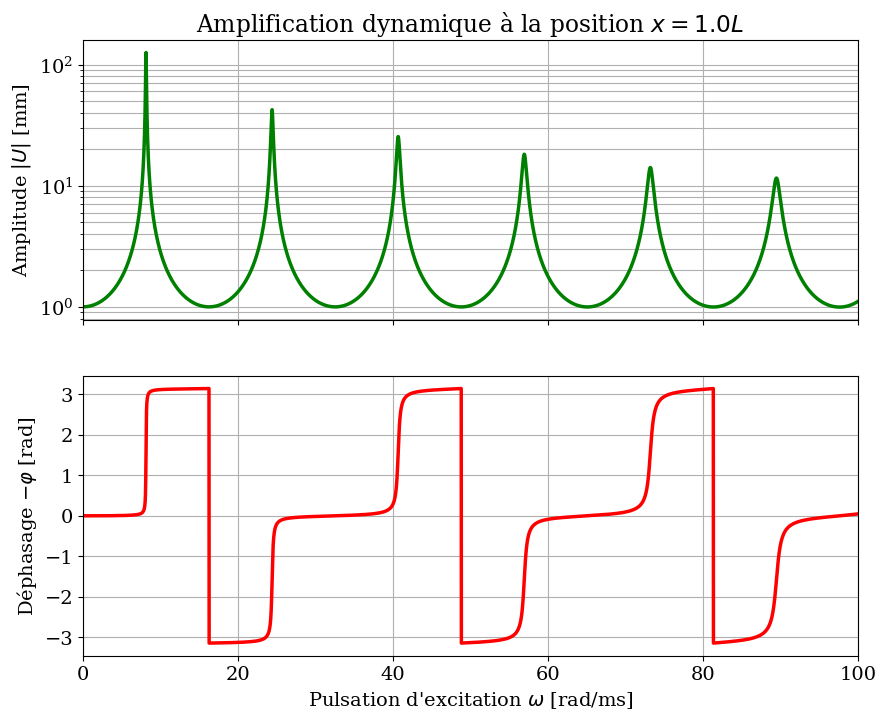

In [3]:
def Ucomplex(w:float, x:float):
    Bstar = w * np.sqrt(rho/Estar)
    U = Ugr * (np.exp(-1j*Bstar*(x-L)) + np.exp(1j*Bstar*(x-L)))/(np.exp(-1j*Bstar*L) + np.exp(1j*Bstar*L))
    return U

xplot = L
allw = np.linspace(0,100, 5000)
allU = Ucomplex(allw, xplot)


fig, axs = plt.subplots(2,1,sharex=True,figsize=(10,8))

axs[0].plot(allw, np.absolute(allU),
    linewidth=2.5,color="green")
axs[1].plot(allw, -np.angle(allU),
    linewidth=2.5,color="red")

axs[0].set_title("Amplification dynamique à la position $x = {0:1.1f}L$".format(xplot/L))
axs[0].set_ylabel("Amplitude $|U|$ [mm]")
axs[0].set_yscale('log', base=10)
axs[0].grid(visible=True, which="both", ls="-")
axs[1].set_xlabel("Pulsation d'excitation $\\omega$ [rad/ms]")
axs[1].set_ylabel("Déphasage $-\\varphi$ [rad]")
axs[1].grid(visible=True)
axs[1].set_xlim(allw.min(), allw.max())

plt.show()


### Réponse temporelle

Revenons en à la réponse temporelle. Comme évoqué, le déplacement réel est obtenu en prenant la partie entière de la solution complexe trouvée :
$$
\boxed{
\mathcal{u}(t,x) 
= \mathcal{R}\big( \mathcal{U}(x)\mathrm{e}^{\mathrm{i}\omega{}t} \big)
= |\mathcal{U}(x)| \cos(\omega{t} - \varphi(x)),}
\quad
\varphi(x) = -\arg(\mathcal{U}(x)).
$$

Note : ici, le module complexe $\mathcal{U}(x)$ est évalué pour la valeur de la pulsation d'excitation, précédemment définie par $\omega_{\mathrm{gr}} = 10\,\mathrm{rad\,ms^{-1}}$.

Nous pouvons tracer le mouvement de la barre sur une demi-période.

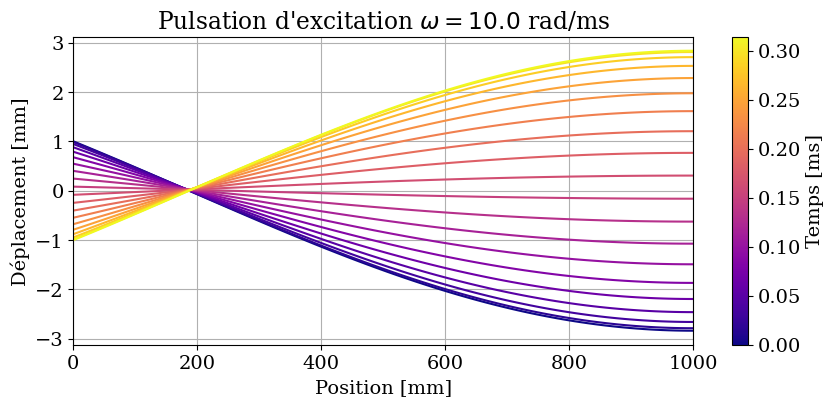

In [4]:
nt = 20
allt = np.linspace(0,np.pi/wgr,nt)
allx = np.linspace(0,L,100)
cmap = colormaps['plasma']
colors = cmap(np.linspace(0, 1, nt))

U = Ucomplex(w=wgr, x=allx)

fig,ax = plt.subplots(figsize = (10,4))
for i, color in enumerate(colors):
    tplot = allt[i]
    ax.plot(allx, np.absolute(U)*np.cos(wgr*tplot + np.angle(U)), color=color)
ax.grid(True)
ax.set_xlim(0,L)
ax.set_xlabel("Position [mm]")
ax.set_ylabel("Déplacement [mm]")
ax.set_title("Pulsation d'excitation $\\omega = {0}$ rad/ms".format(wgr))
fig.colorbar(plt.cm.ScalarMappable(norm=Normalize(0, allt[-1]), cmap=cmap),
             ax=ax, label="Temps [ms]")

plt.show()

Ce graphe présente le déplacement le long de la barre à différent instant (chaque trait de couleur correspond à un instant donné). Pour comprendre ce graphe, il faut se rappeler que la barre se déforme de manière longitudinale (traction/compression uniquement). Ce n'est pas directement l'allure de la configuration déformée qui est représentée ici.

Une représentation un peu différente de la réponse stationnaire peut être éventuellement obtenue en traçant la configuration déformée à différents instants :

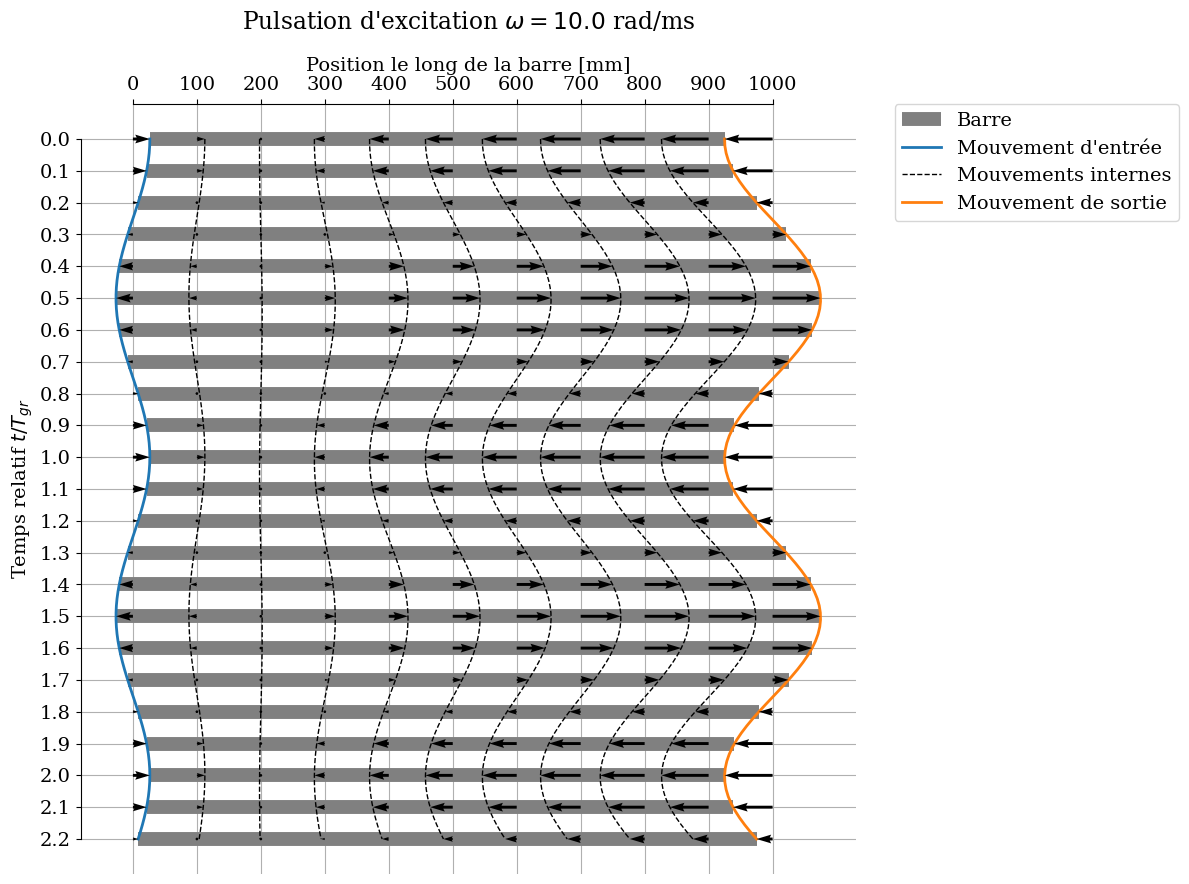

In [5]:
T = 2*np.pi/wgr
npos = 11
xposvertical = np.linspace(0,L,npos)
alltvertical = np.linspace(0,-2.2*T,23)
X, Y = np.meshgrid(xposvertical, alltvertical)

U = np.zeros(X.shape)
for i in range(npos):
    Upos = Ucomplex(w=wgr, x=xposvertical[i])
    U[:,i] = np.absolute(Upos)*np.cos(wgr*alltvertical + np.angle(Upos))
V = np.zeros(X.shape)
fig, ax = plt.subplots(figsize=(10,10))

scale = 0.075*L/np.abs(U).max()
for j in range(alltvertical.size):
    Upos = Ucomplex(w=wgr, x=xposvertical)
    Upos = np.absolute(Upos)*np.cos(wgr*alltvertical[j] + np.angle(Upos))
    line, = ax.plot(xposvertical + scale*Upos, alltvertical[j]*np.ones_like(xposvertical),
        color="gray", linewidth=10)
    line.set_solid_capstyle("butt")
line.set(label="Barre")

alltbounds = np.linspace(alltvertical[0],alltvertical[-1],100)
Upos = Ucomplex(w=wgr, x=xposvertical[0])
ax.plot(xposvertical[0]+scale*np.absolute(Upos)*np.cos(wgr*alltbounds + np.angle(Upos)),alltbounds,
    label="Mouvement d'entrée", linewidth=2)
for i in range(1,npos-1):
    Upos = Ucomplex(w=wgr, x=xposvertical[i])
    curve, = ax.plot(xposvertical[i]+scale*np.absolute(Upos)*np.cos(wgr*alltbounds + np.angle(Upos)),alltbounds,linewidth=1,color="black", linestyle="dashed")
curve.set(label="Mouvements internes")
Upos = Ucomplex(w=wgr, x=xposvertical[-1])
ax.plot(xposvertical[-1]+scale*np.absolute(Upos)*np.cos(wgr*alltbounds + np.angle(Upos)),alltbounds,
    label="Mouvement de sortie", linewidth=2)

q = ax.quiver(X, Y, U, V, scale_units='x', scale=1/scale, color="black", zorder=3)
ax.grid()
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()
ax.set_xticks(xposvertical)
ax.set_xlabel("Position le long de la barre [mm]")
ax.set_yticks(alltvertical,labels=["{0:3.1f}".format(np.abs(t)/T) for t in alltvertical])
ax.set_ylabel("Temps relatif $t/T_{gr}$")

ax.spines.top.set_bounds(0, L)
ax.spines.left.set_bounds(0, alltvertical.min())
ax.spines.right.set_visible(False)
ax.spines.bottom.set_visible(False)
ax.legend(bbox_to_anchor=(1.05, 1),
                         loc='upper left', borderaxespad=0.)
ax.set_title("Pulsation d'excitation $\\omega = {0}$ rad/ms".format(wgr), pad=20)

plt.show()

Remarque : les flèches noires représentent le déplacement aux points $x = 0, 100, 200, \dots, 1000\,\mathrm{mm}$. Les déplacements ont été amplifiés.

Il est intéressant de noter que :

* La barre alterne entre des configurations où elle est étirée, et des configurations où elle est comprimée. 
* L'amplitude des oscillations à l’extrémité droite (côté libre) est plus importante que celle à l'entrée pour une pulsation d'excitation $\omega_{\mathrm{gr}} = 10\,\mathrm{rad\,ms^{-1}}$. La sortie est en opposition de phase avec l'entrée.
* Il y a des zones où le déplacement est très faible, lorsque $x\approx 200\,\mathrm{mm}$. Ces zones sont couramment appelées des *noeuds*.
* Le zéro de l'échelle de temps est fictif. 

#### Efforts internes

Au-delà du déplacement, il est intéressant de regarder les efforts internes dans la barre. En particulier, la contrainte normale est donnée par :
$$
\boxed{
    \sigma_{xx}(t,x) = \mathcal{R}\big(E^* u^{\prime}(t,x)\big).}
$$
où $\mathcal{R}(\cdot)$ est l'opérateur renvoyant la partie réelle du nombre complexe.

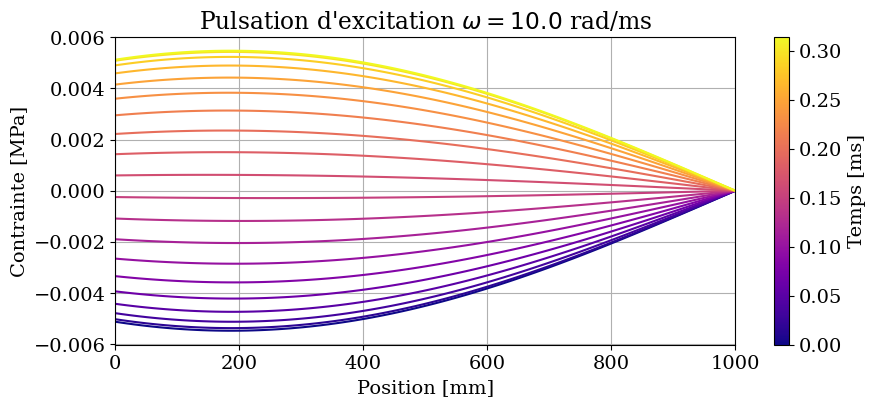

In [6]:
def Scomplex(w:float, x:float):
    Bstar = w * np.sqrt(rho/Estar)
    U = Ugr * Bstar * (-eta + 1.0j) * (-np.exp(-1j*Bstar*(x-L)) + np.exp(1j*Bstar*(x-L)))/(np.exp(-1j*Bstar*L) + np.exp(1j*Bstar*L))
    return U

S = Scomplex(w=wgr, x=allx)

fig,ax = plt.subplots(figsize = (10,4))
for i, color in enumerate(colors):
    tplot = allt[i]
    ax.plot(allx, np.absolute(S)*np.cos(wgr*tplot + np.angle(S)), color=color)
ax.grid(True)
ax.set_xlim(0,L)
ax.set_xlabel("Position [mm]")
ax.set_ylabel("Contrainte [MPa]")
ax.set_title("Pulsation d'excitation $\\omega = {0}$ rad/ms".format(wgr))
fig.colorbar(plt.cm.ScalarMappable(norm=Normalize(0, allt[-1]), cmap=cmap),
             ax=ax, label="Temps [ms]")

plt.show()

Il est intéressant de noter que :

* Une contrainte négative indique une zone en compression, et une contrainte positive indique une zone en traction. Nous voyons bien que la barre oscille entre des cas de compression et de traction.
* La zone la plus sollicitée n'est pas au niveau de l'appui (de la fixation) mais vers $x=200\,\mathrm{mm}$.
* Nous retrouvons bien la condition aux limites imposée en $x=L$ : l'effort y est toujours nul.

#### Cas quasi-statique

Regardons ce qui se passe pour un cas quasi-statique, lorsque la pulsation d'excitation est faible par rapport à la première pulsation de résonance. Nous pouvons tracer un graphe similaire :

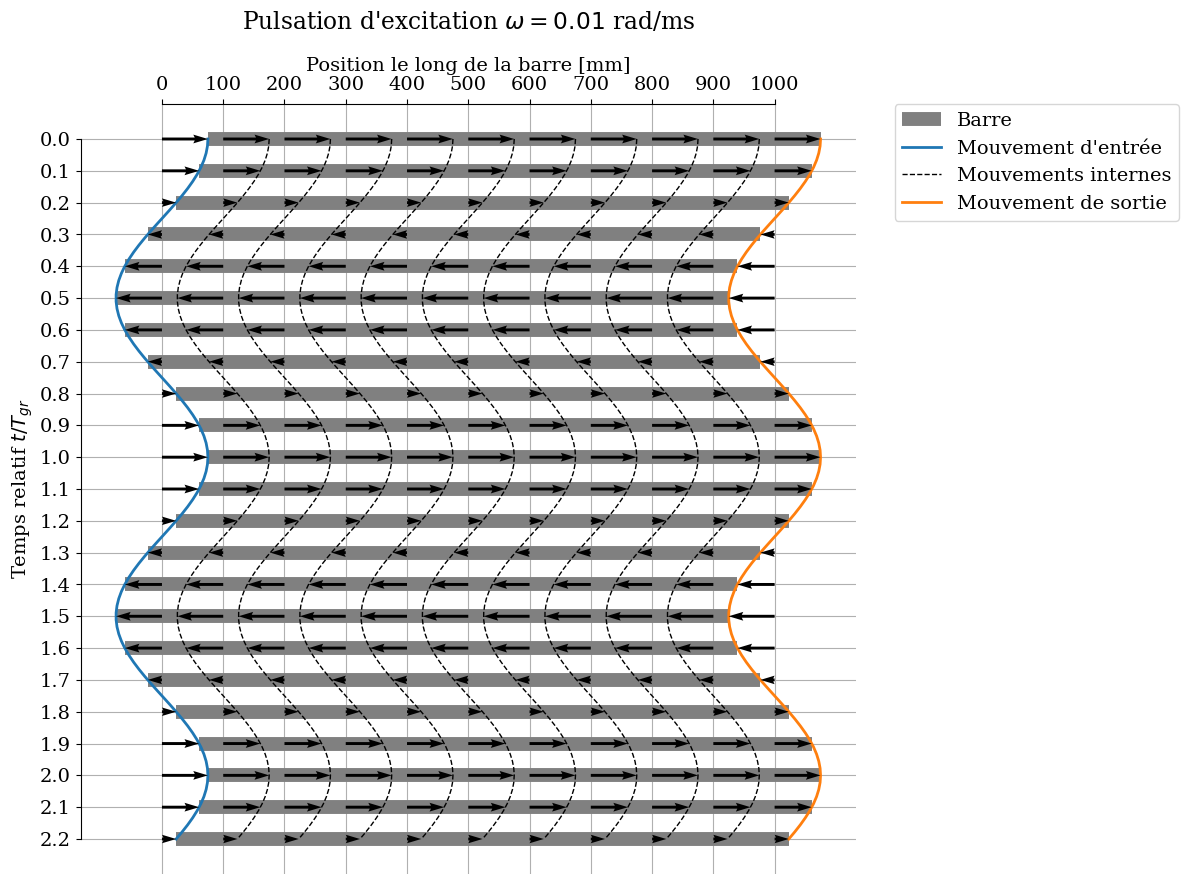

In [7]:
wstatic = 0.01
T = 2*np.pi/wstatic
alltvertical = np.linspace(0,-2.2*T,23)
X, Y = np.meshgrid(xposvertical, alltvertical)

U = np.zeros(X.shape)
for i in range(npos):
    Upos = Ucomplex(w=wstatic, x=xposvertical[i])
    U[:,i] = np.absolute(Upos)*np.cos(wstatic*alltvertical + np.angle(Upos))
V = np.zeros(X.shape)
fig, ax = plt.subplots(figsize=(10,10))

scale = 0.075*L/np.abs(U).max()
for j in range(alltvertical.size):
    Upos = Ucomplex(w=wstatic, x=xposvertical)
    Upos = np.absolute(Upos)*np.cos(wstatic*alltvertical[j] + np.angle(Upos))
    line, = ax.plot(xposvertical + scale*Upos, alltvertical[j]*np.ones_like(xposvertical), color="gray", linewidth=10)
    line.set_solid_capstyle("butt")
line.set(label="Barre")

alltbounds = np.linspace(alltvertical[0],alltvertical[-1],100)
Upos = Ucomplex(w=wstatic, x=xposvertical[0])
ax.plot(xposvertical[0]+scale*np.absolute(Upos)*np.cos(wstatic*alltbounds + np.angle(Upos)),alltbounds,
    label="Mouvement d'entrée", linewidth=2)
for i in range(1,npos-1):
    Upos = Ucomplex(w=wstatic, x=xposvertical[i])
    curve = ax.plot(xposvertical[i]+scale*np.absolute(Upos)*np.cos(wstatic*alltbounds + np.angle(Upos)),alltbounds,linewidth=1,color="black", linestyle="dashed")
curve[0].set(label="Mouvements internes")
Upos = Ucomplex(w=wstatic, x=xposvertical[-1])
ax.plot(xposvertical[-1]+scale*np.absolute(Upos)*np.cos(wstatic*alltbounds + np.angle(Upos)),alltbounds,
    label="Mouvement de sortie", linewidth=2)

q = ax.quiver(X, Y, U, V, scale_units='x', scale=1/scale, color="black", zorder=3)
ax.grid()
ax.xaxis.set_label_position('top')
ax.xaxis.tick_top()
ax.set_xticks(xposvertical)
ax.set_xlabel("Position le long de la barre [mm]")
ax.set_yticks(alltvertical,labels=["{0:3.1f}".format(np.abs(t)/T) for t in alltvertical])
ax.set_ylabel("Temps relatif $t/T_{gr}$")

ax.spines.top.set_bounds(0, L)
ax.spines.left.set_bounds(0, alltvertical.min())
ax.spines.right.set_visible(False)
ax.spines.bottom.set_visible(False)
ax.legend(bbox_to_anchor=(1.05, 1),
                         loc='upper left', borderaxespad=0.)
ax.set_title("Pulsation d'excitation $\\omega = {0}$ rad/ms".format(wstatic), pad=20)

plt.show()

La barre se déplace uniquement, elle ne se déforme pas ! A un instant donné, le déplacement est le même tout le long de barre. En particulier, le mouvement de l'extrémité libre est le même que le mouvement de l'extrémité fixée au support en mouvement (même amplitude, en phase). 

## Décompostion modale

Le résultat précédent peut être obtenu (ou bien approché) à partir de la méthode de décomposition modale.

### Modes de vibration

Les modes de vibrations d'une barre encastrée d'un côté et laissé libre de l'autre sont bien particulière de l'équation du mouvement, solutions de la forme :
$$
\boxed{
u(t,x) = U(x)\cos(\omega{}t - \varphi).}
$$
Il s'agit de trouver les couples $(\omega_j, U_j(x))$ vérifiant à la fois l'équation du mouvement et les conditions aux limites du problème, c'est-à-dire :
$$
\left\{
    \begin{array}{l}
        \rho A\,\ddot{u}(t,x)
        -
        EA\,{u}^{\prime\prime}(t,x)
        = 0, \forall{x},
        \\[3pt]
        {u}(t,x=0) = 0,
        \\[3pt]
        {u}^{\prime}(t,x=L) = 0,
    \end{array},
    \quad\forall{t}.
\right.
$$
Note : modes de vibration $\Leftrightarrow$ pas de terme de dispersion (pas de facteur de perte, on travaille directement dans $\mathbb{R}$).

Par substitution, les modes de vibrations sont solutions de :
$$
\boxed{
\left\{
    \begin{array}{l}
        U^{\prime\prime}(t,x) + \beta^2 U(x)
        = 0, \forall{x},
        \\[3pt]
        U(x=0) = 0,
        \\[3pt]
        U^{\prime}(x=L) = 0.
    \end{array}
\right.
}
$$
Le nombre d'onde est donné par : $\beta = \omega\sqrt{\rho/E}$.

La solution générale pour la forme propre est :
$$
    U(x) = A\cos(\beta{}x) + B\sin(\beta{}x).
$$
Ici, $A$ et $B$ sont deux constantes réelles à déterminer à partir des conditions aux limites :
$$
\begin{split}
U(x=0) = 0 & \quad\Rightarrow\quad \boxed{A = 0}\\
U^{\prime}(x=L) = 0 & \quad\Rightarrow\quad \boxed{B\beta{}\sin(\beta{}L) = 0}
\end{split}
$$
La deuxième équation peut être vérifiée si l'une des conditions suivantes est vraie :
$$
    B = 0, 
    \quad\mathrm{ou}\quad 
    \beta = 0,
    \quad\mathrm{ou}\quad 
    \boxed{\sin(\beta{}L) = 0.}
$$
Les deux premières conditions conduisent à un solution triviale, nulle, pas intéressante : $u(t,x) = 0$. Les modes de vibrations sont donnés par la dernière condition :
$$
\sin(\beta{}L) = 0,
\quad\Rightarrow\quad
\beta{}L = (2j-1)\frac{\pi}{2}, j>1.
$$
Les modes de vibrations sont associés à des nombres d'onde bien spécifiques :
$$
\beta_j = (2j-1)\frac{\pi}{2L},~~j>1,
$$
ou encore, à des pulsations bien spécifiques appelées pulsations propres :
$$
\boxed{
\omega_j = \beta_j\sqrt{\frac{E}{\rho}} = \frac{(2j-1)\pi}{2L}\frac{E}{\rho},~~j>1.
}
$$
Les formes propres associées à ces pulsations propres sont exprimés à une constante près, que nous pouvons arbitrairement choisir égale à 1, soit :
$$
\boxed{
U_j(x) = \sin(\beta_{j}x),~~j>1.}
$$

### Masses et raideurs modales

Nous définissons (voir CM5) les masses et raideurs modales comme :
$$
    m_j = \rho{}A\int_{[0,L]} U_j(x)U_j(x) dx, 
    \quad
    k_j = EA\int_{[0,L]} U_j^\prime(x)U_j^\prime(x) dx,
    \quad\forall{}j\geq{}1.
$$
Masses et raideurs modales sont liées par la relation : $\omega_j = \sqrt{k_j/m_j}$.

Par intégration, nous trouvons :
$$
    m_j 
    = \rho{}A\int_{[0,L]} \sin(\beta_{j}x)\sin(\beta_{j}x) dx
    = \frac{\rho{}A}{2}\int_{[0,L]} (1-\cos(2\beta_{j}x)) dx = \frac{\rho{}A}{2},
$$
et :
$$
    k_j = m_j \omega_j^2 = EA\frac{\beta_j^2 L}{2}.
$$

### Principe de décomposition modale

Il est proposé d'utiliser les deux premiers modes pour approcher la réponse en oscillation forcée de la barre. Ces deux modes sont données par :
$$
\begin{align*}
\beta_1 &= \frac{\pi}{2L}, & \omega_1 &= \beta_1\sqrt{\frac{E}{\rho}}, & U_1 &= \sin(\beta_{1}x) & m_1 &= \frac{\rho{}A}{2}, & k_1 &= EA\frac{\beta_1^2 L}{2}, \\
\beta_2 &= \frac{3\pi}{2L}, & \omega_2 &= \beta_2\sqrt{\frac{E}{\rho}}, & U_2 &= \sin(\beta_{2}x) & m_2 &= \frac{\rho{}A}{2}, & k_2 &= EA\frac{\beta_2^2 L}{2}.
\end{align*}
$$

Pour rappel, le système d'équations décrivant le mouvement de la barre est :
$$
\left\{
    \begin{array}{l}
        \rho A \ddot{\mathcal{u}}(t,x)
        -
        E^*A\,{\mathcal{u}}^{\prime\prime}(t,x)
        = 0, \forall{x},
        \\[3pt]
        \mathcal{u}(t,x=0) = U_{\mathrm{gr}}\mathrm{e}^{\mathrm{i}\omega{}t},
        \\[3pt]
        \mathcal{u}^{\prime}(t,x=L) = 0,
    \end{array},
    \quad\forall{t},
\right.
$$
qui peut être réécrit en mouvement relatif par rapport au support :
$$
\left\{
    \begin{array}{l}
        \rho A \ddot{\mathcal{u}}^*(t,x)
        -
        E^*A\,{\mathcal{u}^*}^{\prime\prime}(t,x)
        = -\rho A \ddot{\mathcal{u}}_{\mathrm{gr}}(t), \forall{x},
        \\[3pt]
        \mathcal{u}^*(t,x=0) = 0,
        \\[3pt]
        {\mathcal{u}^*}^{\prime}(t,x=L) = 0,\\
        \mathcal{u}(t,x) = \mathcal{u}^*(t,x) + \mathcal{u}_{\mathrm{gr}}(t),
    \end{array},
    \quad\forall{t}.
\right.
$$

Le principe de décomposition modale (tronqué), appliqué ici, consiste à chercher une solution approchée de la forme :
$$
\boxed{
    u(t,x) = U_1(x)\alpha_1(t) + U_2(x)\alpha_2(t) + u_{\mathrm{gr}}(t),
}
$$
où les deux amplitudes modales (complexes) sont les solutions de problèmes de vibrations forcées à 1 DDL :
$$
\begin{split}
&
\boxed{
    m_1 \ddot{\alpha}_1(t) + k_1(1+\mathrm{i}\eta)\alpha_1(t) = -\rho{}A\int_{[0,L]} \ddot{\mathcal{u}}_{\mathrm{gr}}(t) U_1(x) dx,} \\
&
\boxed{
    m_2 \ddot{\alpha}_2(t) + k_2(1+\mathrm{i}\eta)\alpha_2(t) = -\rho{}A\int_{[0,L]} \ddot{\mathcal{u}}_{\mathrm{gr}}(t) U_2(x) dx.} 
\end{split}
$$
Les membres de gauche peuvent être vu comme des forces modales, qu'il est possible de calculer analytiquement. Par exemple  :
$$
f_1(t) 
= 
-\rho{}A\int_{[0,L]} \ddot{\mathcal{u}}_{\mathrm{gr}}(t) U_1(x) dx 
= 
-\rho{}A\ddot{\mathcal{u}}_{\mathrm{gr}}(t) \int_{[0,L]} \sin(\beta_{1}x) dx
=
-\frac{\rho{}A}{\beta_1} \ddot{\mathcal{u}}_{\mathrm{gr}}(t),
$$
Le mouvement du support étant harmonique $\mathcal{u}_{\mathrm{gr}}(t) = U_{\mathrm{gr}}\mathrm{e}^{\mathrm{i}\omega{}t}$, nous obtenons comme force modale :
$$
    f_1(t) = \omega^2\frac{\rho{}A}{\beta_1}U_{\mathrm{gr}} \mathrm{e}^{\mathrm{i}\omega{}t}.
$$
Ainsi, l'amplitude modale $\alpha_1(t)$ est solution (particulière) de :
$$
    m_1 \ddot{\alpha}_1(t) + k_1(1+\mathrm{i}\eta)\alpha_1(t) = f_1(t), \quad\forall{t},
$$
ou encore :
$$
\begin{split}
    &\ddot{\alpha}_1(t) + \frac{k_1}{m_1}(1+\mathrm{i}\eta)\alpha_1(t) = \frac{1}{m_1}f_1(t), \quad\forall{t},
    \\
    \Rightarrow\quad&
    \ddot{\alpha}_1(t) + \omega_1^2(1+\mathrm{i}\eta)\alpha_1(t) = \omega^2\frac{2}{\rho{}A}\frac{\rho{}A}{\beta_1}U_{\mathrm{gr}} \mathrm{e}^{\mathrm{i}\omega{}t}, \quad\forall{t},
    \\
    \Rightarrow\quad&
    \boxed{
    \ddot{\alpha}_1(t) + \omega_1^2(1+\mathrm{i}\eta)\alpha_1(t) = U_{\mathrm{gr}} \frac{2\omega^2}{\beta_1} \mathrm{e}^{\mathrm{i}\omega{}t}, \quad\forall{t}.}
\end{split}
$$
Nous pouvons trouver aisément une solution particulière de la forme:
$$
{\alpha}_1(t) = \mathcal{A}_1 \mathrm{e}^{\mathrm{i}\omega{}t}, \quad\mathcal{A}_1\in\mathbb{C}.
$$
Par substitution, nous déduisons l'amplitude complexe :
$$
\begin{split}
    &\big[-\omega^2 + \omega_1^2(1+\mathrm{i}\eta)\big]\mathcal{A}_1 = U_{\mathrm{gr}} \frac{2\omega^2}{\beta_1},
    \\
    \Rightarrow\quad&
    \big[-(\omega/\omega_1)^2 + (1+\mathrm{i}\eta)\big]\mathcal{A}_1 = U_{\mathrm{gr}} \frac{2(\omega/\omega_1)^2}{\beta_1},
    \\
    \Rightarrow\quad&
    \boxed{
    \mathcal{A}_1 = U_{\mathrm{gr}}\frac{4}{\pi}\frac{(\omega/\omega_1)^2}{(1+\mathrm{i}\eta)-(\omega/\omega_1)^2}.}
\end{split}
$$


De manière équivalente, l'amplitude modale $\alpha_2(t)$ est solution de :
$$
    \ddot{\alpha}_2(t) + \omega_2^2(1+\mathrm{i}\eta)\alpha_2(t) = U_{\mathrm{gr}} \frac{2\omega^2}{\beta_2} \mathrm{e}^{\mathrm{i}\omega{}t}, \quad\forall{t},
$$
que nous trouvons égale à :
$$
\boxed{
    \mathcal{A}_2 = U_{\mathrm{gr}}\frac{4}{3\pi}\frac{(\omega/\omega_2)^2}{(1+\mathrm{i}\eta)-(\omega/\omega_2)^2}.}
$$

Une fois les amplitudes complexes obtenues, la solution stationnaire est donnée par :
$$
\boxed{
    u(t,x) 
    = 
    U_1(x) \mathcal{A}_1 \mathrm{e}^{\mathrm{i}\omega{}t} 
    +
    U_2(x) \mathcal{A}_2 \mathrm{e}^{\mathrm{i}\omega{}t} 
    + U_{\mathrm{gr}} \mathrm{e}^{\mathrm{i}\omega{}t} 
    =
    \big[U_1(x) \mathcal{A}_1 + U_2(x) \mathcal{A}_2 + U_{\mathrm{gr}}\big]\mathrm{e}^{\mathrm{i}\omega{}t} 
}
$$
Le terme entre crochet est une approximation du module complexe obtenu en première partie, noté $\mathcal{U}(x)$, soit :
$$
U_1(x) \mathcal{A}_1 + U_2(x) \mathcal{A}_2 + U_{\mathrm{gr}} 
~~\approx~~
\mathcal{U}(x) = U_{\mathrm{gr}}
    \frac{
        \mathrm{e}^{\mathrm{i}\beta^*(L-x)} + \mathrm{e}^{-\mathrm{i}\beta^*(L-x)}
    }
    {
        \mathrm{e}^{-\mathrm{i}\beta^* L} + \mathrm{e}^{\mathrm{i}\beta^* L}
    }.
$$
L'approximation devrait être bonne pour des pulsations d'excitation proches des deux premiers modes de vibrations.

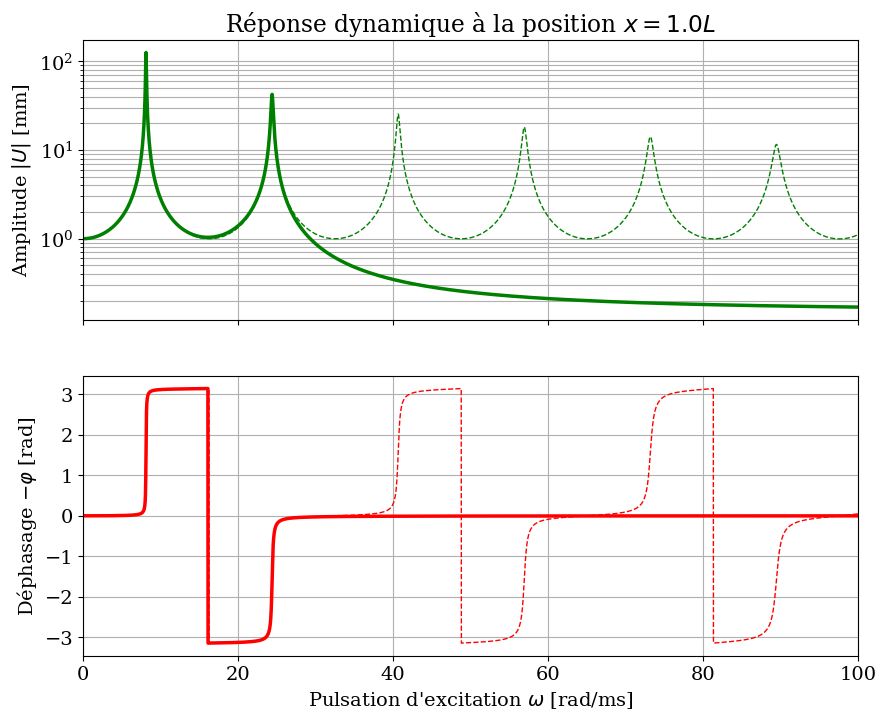

In [8]:
B1 = np.pi/2/L
w1 = B1 * np.sqrt(E/rho)
m1 = rho*A*L/2
k1 = E*A*B1**2*L/2
def U1(x):
    return np.sin(B1*x)
def A1(w:float):
    return Ugr * 4.0/np.pi * (w/w1)**2/((1+1j*eta) - (w/w1)**2)

B2 = 3*np.pi/2/L
w2 = B2 * np.sqrt(E/rho)
m2 = rho*A*L/2
k2 = E*A*B2**2*L/2
def U2(x):
    return np.sin(B2*x)
def A2(w:float):
    return Ugr * 4.0/np.pi/3.0 * (w/w2)**2/((1+1j*eta) - (w/w2)**2)

def UcomplexApprox(w:float, x:float):
    U = Ugr + U1(x)*A1(w) + U2(x)*A2(w)
    return U

allUapprox = UcomplexApprox(allw, xplot)

fig, axs = plt.subplots(2,1,sharex=True,figsize=(10,8))

axs[0].plot(allw, np.absolute(allU),
    linewidth=1.0,color="green", linestyle="dashed")
axs[0].plot(allw, np.absolute(allUapprox),
    linewidth=2.5,color="green")
axs[1].plot(allw, -np.angle(allU),
    linewidth=1.0,color="red", linestyle="dashed")
axs[1].plot(allw, -np.angle(allUapprox),
    linewidth=2.5,color="red")

axs[0].set_title("Réponse dynamique à la position $x = {0:1.1f}L$".format(xplot/L))
axs[0].set_ylabel("Amplitude $|U|$ [mm]")
axs[0].set_yscale('log', base=10)
axs[0].grid(visible=True, which="both", ls="-")
axs[1].set_xlabel("Pulsation d'excitation $\\omega$ [rad/ms]")
axs[1].set_ylabel("Déphasage $-\\varphi$ [rad]")
axs[1].grid(visible=True)
axs[1].set_xlim(allw.min(), allw.max())

plt.show()


### Réponse temporelle approchée

Finalement, il est possible de retrouver la réponse temporelle de manière équivalent à la solution exacte. Malgré qu'uniquement deux modes de vibrations aient été retenus, nous retrouvons les mêmes résultats que précédemment (à l'oeil nu en tout cas). Cela fonctionne car la pulsation d'excitation considérée $\omega_{\mathrm{gr}}$ est de la plage donnée par les deux modes pris en compte. Pour des valeurs de pulsation d'excitation plus grande, l'approximation serait mauvaise et il faudrait considérer plus de modes de vibrations dans le principe de décomposition modale.

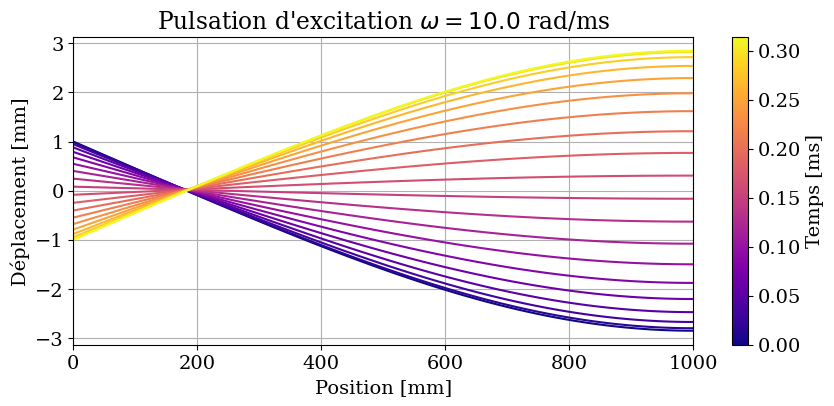

In [9]:
U = UcomplexApprox(w=wgr, x=allx)

fig,ax = plt.subplots(figsize = (10,4))
for i, color in enumerate(colors):
    tplot = allt[i]
    ax.plot(allx, np.absolute(U)*np.cos(wgr*tplot + np.angle(U)), color=color)
ax.grid(True)
ax.set_xlim(0,L)
ax.set_xlabel("Position [mm]")
ax.set_ylabel("Déplacement [mm]")
ax.set_title("Pulsation d'excitation $\\omega = {0}$ rad/ms".format(wgr))
fig.colorbar(plt.cm.ScalarMappable(norm=Normalize(0, allt[-1]), cmap=cmap),
             ax=ax, label="Temps [ms]")

plt.show()